In [28]:
from config import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

runtime_df = pd.read_parquet(f"{RUNTIME_DIR}/all_gpus_preprocessed.parquet")
gpu_mapping = {'2080': '2080Ti', '1080': '1080Ti', 'a40': 'A40', 'p100': 'P100', 'v100': 'V100'}

runtime_df.GPU = runtime_df.GPU.astype(str).apply(lambda x: gpu_mapping[x])
runtime_df.head()

,dataset,speedup,operator,num_cores,selectivity,cardinality_T,cardinality_S,join,GPU,dataset_type,...,nnz_S,r_T,c_T,sparsity_T,sparsity_S,morpheusfi_p,morpheusfi_q,morpheusfi_eis,morpheusfi_ns,morpheusfi_nis
index,,,,,,,,,,,,,,,,,,,,,
0,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,1.163286,Noop,-1,1.05385,100000,105385,preset,2080Ti,synthetic,...,"b'[100000,53850]'",100000,11,0.0,"b'[0.0,0.0]'",2,0,b'[0.0]',100000,b'[5385]'
1,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.967651,Noop,-1,1.05385,100000,105385,preset,1080Ti,synthetic,...,"b'[100000,53850]'",100000,11,0.0,"b'[0.0,0.0]'",2,0,b'[0.0]',100000,b'[5385]'
2,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,1.171650,Noop,-1,1.05385,100000,105385,preset,A40,synthetic,...,"b'[100000,53850]'",100000,11,0.0,"b'[0.0,0.0]'",2,0,b'[0.0]',100000,b'[5385]'
3,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.960434,Noop,-1,1.05385,100000,105385,preset,P100,synthetic,...,"b'[100000,53850]'",100000,11,0.0,"b'[0.0,0.0]'",2,0,b'[0.0]',100000,b'[5385]'
4,/mnt/data/synthetic/sigmod_extended/100k/n_R=1...,0.985006,Noop,-1,1.05385,100000,105385,preset,V100,synthetic,...,"b'[100000,53850]'",100000,11,0.0,"b'[0.0,0.0]'",2,0,b'[0.0]',100000,b'[5385]'


In [8]:
pd.read_csv("./tables/gpu-metrics/gpu-metrics.tsv", delimiter="\t", thousands=',')


,Group,Characteristic,Unit,P100,1080Ti,V100,2080Ti,1660Ti,A40
0,NaN,Architecture,NaN,Pascal,Pascal,Volta,Turing,Turing,Ampere
1,NaN,Number of SM,NaN,56,28,80,68,24,84
2,NaN,Cores,NaN,"3,584","3,584","5,120","4,352","1,536","10,752"
3,Cache Size,L1,KB/SM,24,48,128,64,64,128
4,Cache Size,L2,MB,4.0,2.8,6.2,5.5,1.5,6.0
5,Clock Speed,Base,MHz,"1,126","1,480","1,230","1,350","1,500","1,305"
6,Clock Speed,Max Boost,MHz,"1,303","1,582","1,370","1,545","1,770","1,740"
7,Memory,Bus Width,bit,"4,096",352,"4,096",352,192,384
8,Memory,Size,GB,16,11,32,11,6,48
9,Memory,Clock,MT/S,"1,430","11,000","1,750","14,000","12,000","7,248"


In [9]:
from io import StringIO


df = pd.read_csv("./tables/gpu-metrics/gpu-metrics.tsv", delimiter="\t", thousands=",")

df.fillna("", inplace=True)
df["characteristic"] = df.apply(
    lambda row: row["Group"].lower().replace(" ", "_") + "." + row["Characteristic"].lower().replace(" ", "_"), axis=1
).apply(lambda x: x[1:] if x.startswith(".") else x)
df.drop(columns=["Group", "Characteristic", "Unit"], inplace=True)
df = df.T
df.columns = df.tail(1).values[0]
df = df[:-1]
df.index.name = "GPU"
gpu_chars = pd.read_csv(StringIO(df.to_csv()), thousands=",")
gpu_chars.GPU = gpu_chars.GPU.astype(str)
gpu_chars

,GPU,architecture,number_of_sm,cores,cache_size.l1,cache_size.l2,clock_speed.base,clock_speed.max_boost,memory.bus_width,memory.size,memory.clock,memory.bandwidth,processing_power.half_precision,processing_power.single_precision,processing_power.double_precision
0,P100,Pascal,56,3584,24,4.0,1126,1303,4096,16,1430,732,21.20,10.60,5.30
1,1080Ti,Pascal,28,3584,48,2.8,1480,1582,352,11,11000,484,0.17,10.61,0.33
2,V100,Volta,80,5120,128,6.2,1230,1370,4096,32,1750,900,112.22,14.03,7.01
3,2080Ti,Turing,68,4352,64,5.5,1350,1545,352,11,14000,616,23.50,11.75,0.32
4,1660Ti,Turing,24,1536,64,1.5,1500,1770,192,6,12000,288,9.22,4.61,0.14
5,A40,Ampere,84,10752,128,6.0,1305,1740,384,48,7248,696,149.68,37.42,1.17


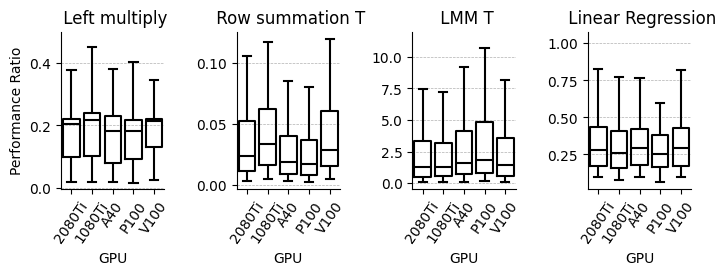

In [22]:
df = runtime_df.merge(gpu_chars, on="GPU")
df = df[df.dataset.str.contains("/mnt/")]
df = df[~df.operator.isin(["Noop", "Materialization"])]
operators = ["Row summation T", "LMM T", "Linear Regression", "Left multiply"]

# df = df[df.speedup>1.0]
# x='GPU'
# df.sort_values(by=[x], ascending=True, inplace=True)
# ax = sns.catplot(data=df, kind='box', x='GPU', y='speedup', col='operator', col_wrap=5, sharex=False, sharey=False, fliersize=0)
# ax = sns.catplot(data=df[df.operator.isin(operators)], kind='box', x='GPU', y='speedup', col='operator', col_wrap=5, height=4, aspect=0.5, sharex=False, sharey=False, fill=False, fliersize=0, color='black')
facet_grid = sns.catplot(
    data=df[df.operator.isin(operators)],
    kind="box",
    x="GPU",
    y="speedup",
    col="operator",
    # col_wrap=5,
    height=2.5,
    aspect=0.7,
    sharex=False,
    sharey=False,
    fill=False,
    fliersize=0,
    color="black",
)
facet_grid.tick_params(axis="x", rotation=55)
facet_grid.set_ylabels("Performance Ratio")
axes = facet_grid.axes.flatten()

for i, ax in enumerate(axes):
    ax.set_title(ax.get_title().split("=")[1])
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
    if i == 0:
        ax.set_ylim(axes[1].get_ylim()[0], 0.5)

facet_grid.savefig(f"{LATEX_PROJECT_BASE_PATH}/chapters/05_cost_estimation/figures/motivation_speedup_per_operator_per_gpu.pdf", bbox_inches="tight")

In [ ]:
df['speedup_gte_1'] = df.speedup > 1.0
avg_speedup_df = df[df.speedup_gte_1].groupby(['GPU']).agg({'speedup': ['mean', 'count', 'std']})
# avg_speedup_df.speedup['mean'] = avg_speedup_df.speedup['mean']
avg_speedup_df


speedup                
          mean count       std
GPU                           
1080  2.278117  4360  1.676298
2080  2.345109  4422  1.823327
a40   2.455286  5113  2.048753
p100  2.842746  4822  2.430945
v100  2.469009  4586  2.088668